# Imports

In [148]:
import requests
from bs4 import BeautifulSoup
import re
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import urllib.request

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

import time

from sklearn.linear_model import LinearRegression

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Functions to format strings

In [2]:
def format_baths(baths_str):

    if '-' in baths_str:
        left, right = baths_str.split(' - ')
        return format_baths(left) + ' - ' + format_baths(right)

    return re.findall(r'\d+', baths_str)[0]

In [3]:
def format_beds(beds_str):

    if '-' in beds_str:
        left, right = beds_str.split(' - ')
        return format_beds(left) + ' - ' + format_beds(right)

    if beds_str == 'Studio':
        return '0'

    return re.findall(r'\d+', beds_str)[0]

# Main work horse
This function loops over each property in the `properties` list and gets data from it. It formats the data into a semi-workable format. It temporarily saves this data in a dictionary before converting to a Pandas DataFrame.

In [4]:
def get_property_df(properties):

    property_data = {
        'buy_type': [],
        'desc': [],
        'address': [],
        'price': [],
        'beds': [],
        'baths': [],
        'sqft': [],
        'pets': []
    }

    for property in properties:

        try:
            prop_description = property.find_all('div', attrs={'data-testid': 'card-description'})[0].text
            
            rent_or_sale = prop_description.split(' ')[1].lower()
            house_or_apartment = prop_description.split(' ')[3].lower()

            price = property.find_all('div', attrs={'data-testid': 'card-price'})[0].text

            address_line_1 = property.find_all('div', attrs={'data-testid': 'card-address-1'})[0].text
            address_line_2 = property.find_all('div', attrs={'data-testid': 'card-address-2'})[0].text
            address = address_line_1 + ', ' + address_line_2

            beds = property.find_all('li', attrs={'data-testid': 'property-meta-beds'})
            if len(beds) == 0:
                beds = 'nan'
            else:
                beds = format_beds(beds[0].text)
            
            baths = property.find_all('li', attrs={'data-testid': 'property-meta-baths'})
            if len(baths) == 0:
                baths = 'nan'
            else:
                baths = format_baths(baths[0].text)

            sqft = property.find_all('li', attrs={'data-testid': 'property-meta-sqft'})
            if len(sqft) == 0:
                sqft = 'nan'
            else:
                sqft = sqft[0].text
                sqft = sqft.split('sqft')[0]

            pets = property.find_all('li', attrs={'data-testid': 'property-meta-pet'})
            if len(pets) == 0:
                pets = 'nan'
            else:
                pets = pets[0].text
                pets = pets.split('OK')[0]
                pets = pets.lower()
                if pets == 'pets':
                    pets = 'all pets'

            # try:
            #     image_source = property.find_all('div', attrs={'class': 'Picture_photo-wrap__CDzzG'})[0].find_all('img')[0]['srcset']
            #     if ',' in image_source:
            #         image_source = image_source.split(',')[0]
            #     print(image_source)
            #     # image = requests.get(image_source)
            #     # if image.status_code == 200:
            #     #     urllib.request.urlretrieve(image_source, f"images/{address.replace(' ', '+')}.jpg")
            # except:
            #     continue

            property_data['buy_type'].append(rent_or_sale)
            property_data['desc'].append(house_or_apartment)
            property_data['address'].append(address)
            property_data['price'].append(price)
            property_data['beds'].append(beds)
            property_data['baths'].append(baths)
            property_data['sqft'].append(sqft)
            property_data['pets'].append(pets)

        except IndexError:
            continue

    return pd.DataFrame(property_data)

# Formats minimum and maximum values

In [5]:
def format_min_and_max(value):
    value = value.replace('$', '')
    value = value.replace(',', '')

    if ' - ' in value:
        return value.split(' - ')
    
    return value, value

# Main loop
Loops over pages 1-5 of the Realator.com apartments search page for Greenville, SC. Aggregates Pandas DataFrames from the function `get_property_df`. End result is one DataFrame, `df`, that contains all the data.

In [6]:
min_price = 1000
max_price = 1600

headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"}

df = None

for page_number in range(1, 6):
    url = f"https://www.realtor.com/apartments/Greenville_SC/pg-{page_number}"

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    properties = soup.find_all('div', attrs={'class': "BasePropertyCard_propertyCardWrap__pblQC"})

    property_df = get_property_df(properties)
    if df is None:
        df = property_df
    else:
        df = pd.concat((df, property_df))

    print(page_number)

1
2
3
4
5


# Formats data to final form

In [7]:
min_and_max_columns = ['price', 'beds', 'baths', 'sqft']

for col in min_and_max_columns:
    df[[f'min_{col}', f'max_{col}']] = df.apply(lambda x: format_min_and_max(x[col]), axis=1, result_type='expand')

df.drop(columns=min_and_max_columns, inplace=True)
df.reset_index(inplace=True, drop=True)

df[['min_price', 'max_price', 'min_beds', 'max_beds', 'min_baths', 'max_baths', 'min_sqft', 'max_sqft']] = df[['min_price', 'max_price', 'min_beds', 'max_beds', 'min_baths', 'max_baths', 'min_sqft', 'max_sqft']].astype('float')

In [8]:
df

,buy_type,desc,address,pets,min_price,max_price,min_beds,max_beds,min_baths,max_baths,min_sqft,max_sqft
0,rent,apartment,"208 E Stone Ave Apt 6, Greenville, SC 29609",nan,650.0,650.0,1.0,1.0,1.0,1.0,600.0,600.0
1,rent,apartment,"326 Loop St Apt F, Greenville, SC 29609",nan,800.0,800.0,2.0,2.0,1.0,1.0,NaN,NaN
2,rent,house,"204 Honour St, Greenville, SC 29611",nan,900.0,900.0,3.0,3.0,2.0,2.0,1360.0,1360.0
3,rent,apartment,"622 Perry Rd Unit 1, Greenville, SC 29609",nan,1295.0,1295.0,2.0,2.0,1.0,1.0,NaN,NaN
4,rent,townhome,"18 E Stone Ave Unit 3-104, Greenville, SC 29609",nan,1265.0,1265.0,1.0,1.0,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
204,rent,house,"1024 N Franklin Rd, Greenville, SC 29617",nan,1295.0,1295.0,2.0,2.0,1.0,1.0,1272.0,1272.0
205,rent,condo,"433 McKenna Cir Unit 433, Greenville, SC 29615",nan,1295.0,1295.0,3.0,3.0,2.0,2.0,1296.0,1296.0
206,rent,house,"101 Sharon Dr, Greenville, SC 29617",all pets,1650.0,1650.0,4.0,4.0,2.0,2.0,1430.0,1430.0
207,rent,house,"1612 W Blue Ridge Dr, Greenville, SC 29611",nan,750.0,750.0,1.0,1.0,1.0,1.0,NaN,NaN


# Plots and Analyses

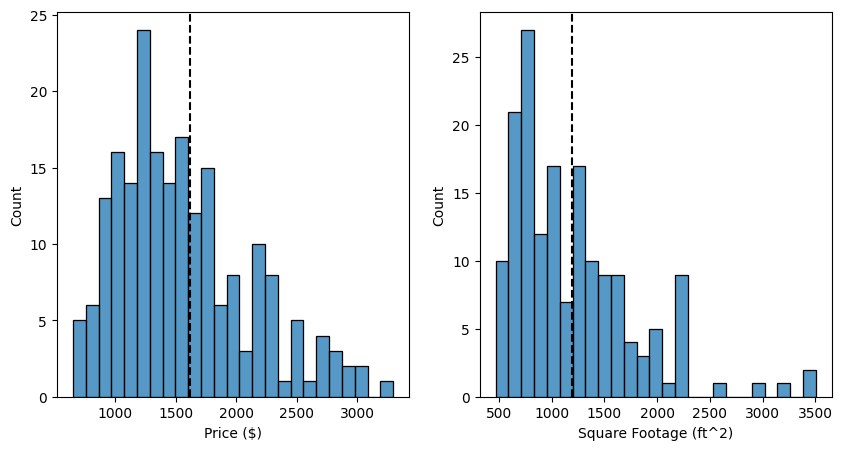

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.histplot(x='min_price', data=df[df['min_price'] < 4000], bins=25, ax=axs[0])
axs[0].axvline(df['min_price'].mean(), linestyle='--', color='k')
axs[0].set_xlabel('Price ($)')

sns.histplot(x='min_sqft', data=df, bins=25, ax=axs[1])
axs[1].axvline(df['min_sqft'].mean(), linestyle='--', color='k')
axs[1].set_xlabel('Square Footage (ft^2)')
plt.show()

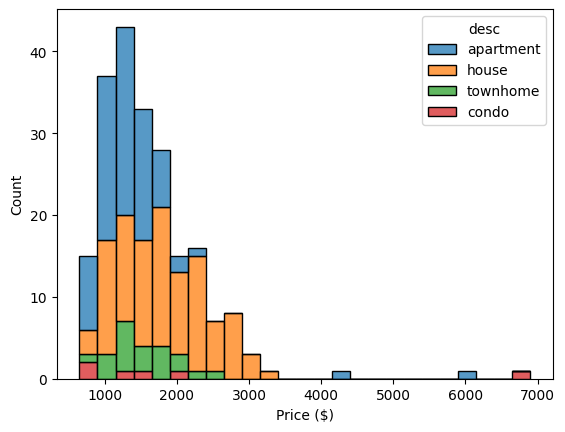

In [10]:
sns.histplot(x='min_price', data=df, hue='desc', multiple='stack')

plt.xlabel('Price ($)')
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


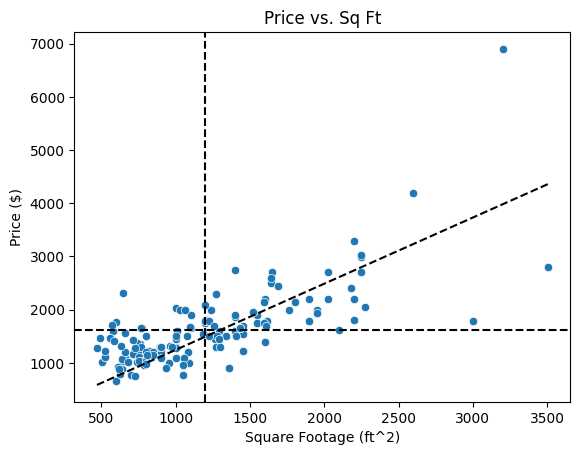

In [11]:
sns.scatterplot(x='min_sqft', y='min_price', data=df)

plt.axvline(df['min_sqft'].mean(), linestyle='--', color='k')
plt.axhline(df['min_price'].mean(), linestyle='--', color='k')

lm = LinearRegression(fit_intercept=False)
no_na = df.dropna()
X = no_na[['min_sqft']]
y = no_na[['min_price']]
lm.fit(X, y)

xs = np.linspace(df.min_sqft.min(), df.min_sqft.max()).reshape(-1, 1)
plt.plot(xs, lm.predict(xs), linestyle='--', color='k')

plt.xlabel('Square Footage (ft^2)')
plt.ylabel('Price ($)')
plt.title('Price vs. Sq Ft')
plt.show()

## Over Performers -- Big and Cheap

In [12]:
over_performers = df[(df.min_sqft > df.min_sqft.mean()) & (df.min_price < df.min_price.mean())].sort_values(by='min_price')
over_performers

,buy_type,desc,address,pets,min_price,max_price,min_beds,max_beds,min_baths,max_baths,min_sqft,max_sqft
2,rent,house,"204 Honour St, Greenville, SC 29611",nan,900.0,900.0,3.0,3.0,2.0,2.0,1360.0,1360.0
127,rent,house,"204 Honour St, Greenville, SC 29611",nan,900.0,900.0,3.0,3.0,2.0,2.0,1360.0,1360.0
122,rent,apartment,"110 Prospect St Unit 1, Greenville, SC 29611",all pets,1225.0,1225.0,3.0,3.0,1.0,1.0,1450.0,1450.0
163,rent,apartment,"110 Prospect St Unit 1, Greenville, SC 29611",all pets,1225.0,1225.0,3.0,3.0,1.0,1.0,1450.0,1450.0
204,rent,house,"1024 N Franklin Rd, Greenville, SC 29617",nan,1295.0,1295.0,2.0,2.0,1.0,1.0,1272.0,1272.0
205,rent,condo,"433 McKenna Cir Unit 433, Greenville, SC 29615",nan,1295.0,1295.0,3.0,3.0,2.0,2.0,1296.0,1296.0
190,rent,apartment,"15 Backwater Way, Greenville, SC 29611",nan,1400.0,1400.0,4.0,4.0,2.0,2.0,1600.0,1600.0
162,rent,apartment,"36 Miracle Dr Unit 1, Greenville, SC 29605",nan,1450.0,1450.0,3.0,3.0,2.0,2.0,1266.0,1266.0
187,rent,apartment,"2808 E North St, Greenville, SC 29615",nan,1450.0,1450.0,2.0,2.0,1.0,1.0,1292.0,1292.0
182,rent,townhome,"40 Wood Pointe Dr Apt 83, Greenville, SC 29615",all pets,1495.0,1495.0,2.0,2.0,2.0,2.0,1224.0,1224.0


In [19]:
with open('secrets.json', 'r') as file:
    secrets = json.load(file)
    API_KEY = secrets['GOOGLE_API_KEY']

In [32]:
def get_geo(address):
    base_url= "https://maps.googleapis.com/maps/api/geocode/json?"
    parameters = {"address": address,
                "key": API_KEY}
    r = requests.get(f"{base_url}{urllib.parse.urlencode(parameters)}")
    data = json.loads(r.content)
    try:
        geo_location = data.get("results")[0].get("geometry").get("location")
        return geo_location['lat'], geo_location['lng']
    except:
        return np.nan, np.nan

over_performers[['lat', 'lng']] = over_performers.apply(lambda x: get_geo(x['address']), axis=1, result_type='expand')
over_performers

In [102]:
street_map = gpd.read_file('Streets.shp')
street_map = street_map.to_crs('EPSG:4326')

In [147]:
geometry = [Point(xy) for xy in zip(over_performers['lng'], over_performers['lat'])]
geo_df = gpd.GeoDataFrame(over_performers, geometry=geometry, crs={'init': 'EPSG:4326'})
geo_df

/home/codespace/.python/current/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,buy_type,desc,address,pets,min_price,max_price,min_beds,max_beds,min_baths,max_baths,min_sqft,max_sqft,lat,lng,geometry
2,rent,house,"204 Honour St, Greenville, SC 29611",nan,900.0,900.0,3.0,3.0,2.0,2.0,1360.0,1360.0,34.832828,-82.424305,POINT (-82.42430 34.83283)
127,rent,house,"204 Honour St, Greenville, SC 29611",nan,900.0,900.0,3.0,3.0,2.0,2.0,1360.0,1360.0,34.832828,-82.424305,POINT (-82.42430 34.83283)
122,rent,apartment,"110 Prospect St Unit 1, Greenville, SC 29611",all pets,1225.0,1225.0,3.0,3.0,1.0,1.0,1450.0,1450.0,34.819235,-82.431073,POINT (-82.43107 34.81924)
163,rent,apartment,"110 Prospect St Unit 1, Greenville, SC 29611",all pets,1225.0,1225.0,3.0,3.0,1.0,1.0,1450.0,1450.0,34.819235,-82.431073,POINT (-82.43107 34.81924)
204,rent,house,"1024 N Franklin Rd, Greenville, SC 29617",nan,1295.0,1295.0,2.0,2.0,1.0,1.0,1272.0,1272.0,34.893698,-82.427051,POINT (-82.42705 34.89370)
205,rent,condo,"433 McKenna Cir Unit 433, Greenville, SC 29615",nan,1295.0,1295.0,3.0,3.0,2.0,2.0,1296.0,1296.0,34.878224,-82.315689,POINT (-82.31569 34.87822)
190,rent,apartment,"15 Backwater Way, Greenville, SC 29611",nan,1400.0,1400.0,4.0,4.0,2.0,2.0,1600.0,1600.0,34.810029,-82.471362,POINT (-82.47136 34.81003)
162,rent,apartment,"36 Miracle Dr Unit 1, Greenville, SC 29605",nan,1450.0,1450.0,3.0,3.0,2.0,2.0,1266.0,1266.0,34.804791,-82.415156,POINT (-82.41516 34.80479)
187,rent,apartment,"2808 E North St, Greenville, SC 29615",nan,1450.0,1450.0,2.0,2.0,1.0,1.0,1292.0,1292.0,34.869727,-82.347663,POINT (-82.34766 34.86973)
182,rent,townhome,"40 Wood Pointe Dr Apt 83, Greenville, SC 29615",all pets,1495.0,1495.0,2.0,2.0,2.0,2.0,1224.0,1224.0,34.867161,-82.334212,POINT (-82.33421 34.86716)


In [150]:
hospital_df = pd.DataFrame({
    'location': ['Greenville Memorial Hospital'],
    'lat': [34.8188051257128],
    'lng': [-82.41297623609863]
})
hospital_geometry = [Point(xy) for xy in zip(hospital_df['lng'], hospital_df['lat'])]
hospital_geo_df = gpd.GeoDataFrame(hospital_df, geometry=hospital_geometry, crs={'init': 'EPSG:4326'})
hospital_geo_df

/home/codespace/.python/current/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,location,lat,lng,geometry
0,Greenville Memorial Hospital,34.818805,-82.412976,POINT (-82.41298 34.81881)


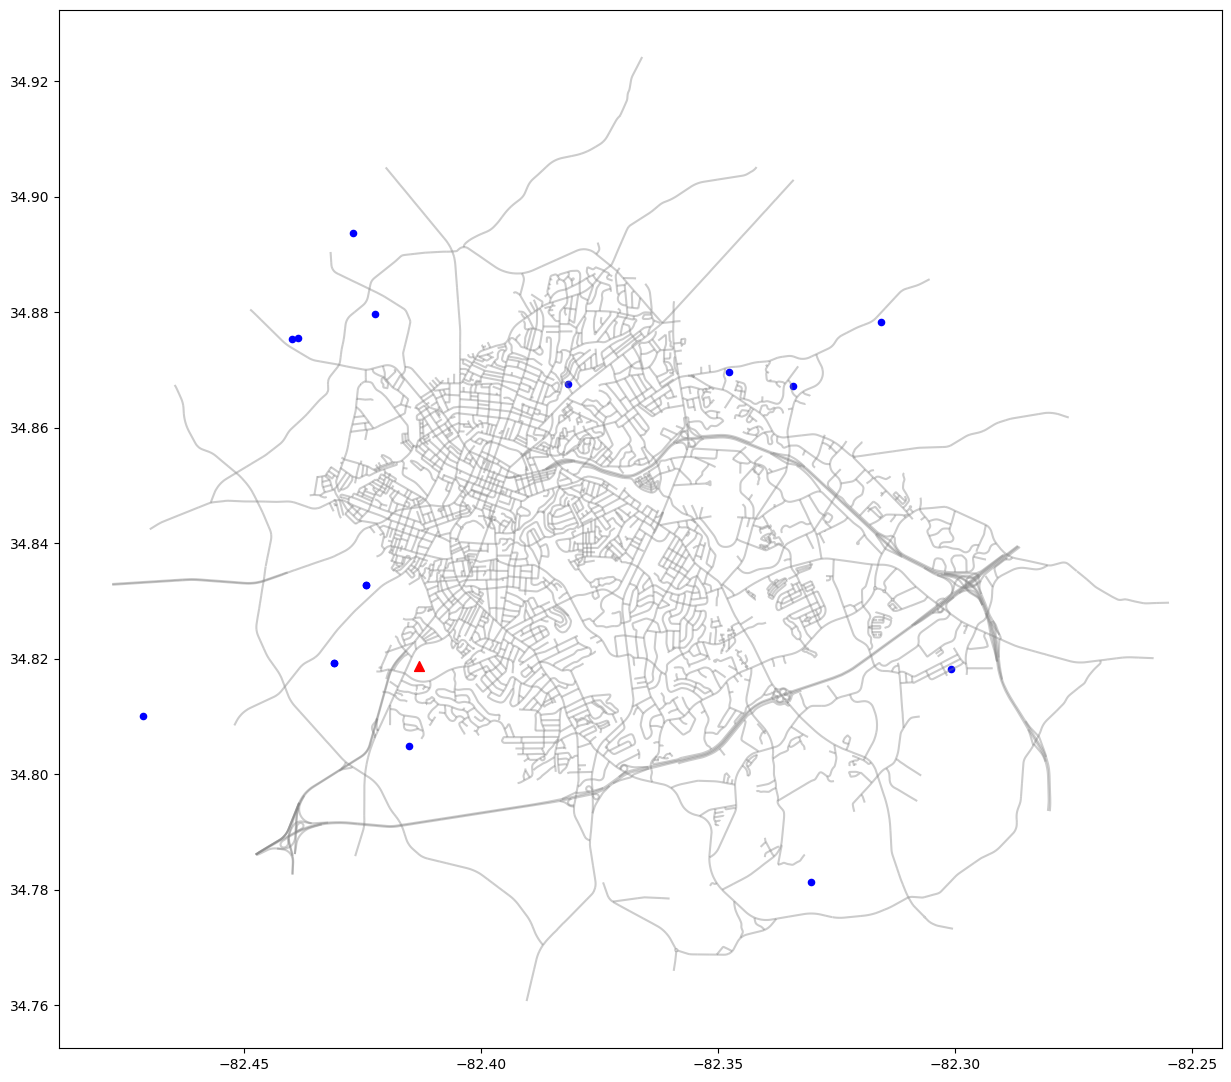

In [153]:
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(ax=ax, markersize=20, color='blue', marker='o')
hospital_geo_df.plot(ax=ax, markersize=50, color='red', marker='^')
plt.show()